### Regression and Time Series Prediction: Training and Testing

As we've noticed in power flow problems we've been looking at in class, grid operators are constrained by the physics of electricity. Chief amongst these: the power supplied to the network need to equal the demand at _each moment in time_. Scheduling production amongst many power generators is a non-trivial task since they are expensive to start and run and the generation schedule needs to be adaptable to rapid fluctuations in demand. This problem is known as _generator dispatch_: a grid operator wants to minimize the cost of generating electricity while ensuring enough power is being generated in reserve because of unexpected increases in demand or failures in the grid. 

Fig. 1 illustrates the total power demand in the Texas electrical market (ERCOT) in 2017. Recall Hurricane Harvey caused massive flooding in Houston in late August that year; the red line in Fig. 1 marks 24 hours prior to Hurricane Harvey hitting Houston and causing widespread outages in one of the largest cities in Texas.

<center>Fig. 1</center>

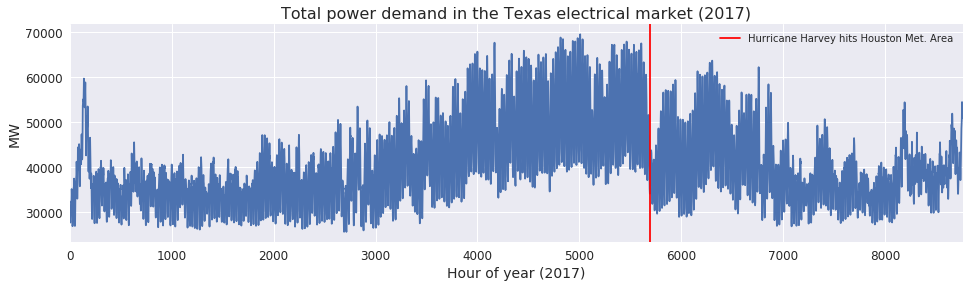

We are not going to do forecasting on the ERCOT data yet. A good prediction there will require a lot of features. Here, we will work with a simpler example where we generate the data. 

The first step in setting the generation schedule is predicting how much power will be consumed by the grid at future time steps. We're going to suppose that our job is to predict how much power the grid will consume in the _next_ hour for a given day. We'll suppose that for a typical day, each hour can be predicted as a function of the previous hour's power consumption and a number of other features, like temperature, humidity, time of day, etc. Let $\boldsymbol{x}_{t} = \langle x_{i,t} \rangle$ where each vector component $i$ is one of these data features at time $t$, and $\boldsymbol{p}_{t+1}$ is the power consumed at time $t + 1$. If this function is linear, then,

<center>$\boldsymbol{p}_{t+1} = w^{T}\boldsymbol{x}_{t}$</center>

where $w$ is the vector of weights we would solve for in the standard linear regression problem. From the slides, this is an autoregressive model of order 1, meaning the next time step only depends on the previous. Including previous historical values (i.e. $x_{t-1}, x_{t-2}\ldots$) increases the order:

<center>$\boldsymbol{p}_{t+1} = w_{1}^{T}\boldsymbol{x}_{t} + w_{2}^{T}\boldsymbol{x}_{t - 1}\ldots$</center>

<center>Fig. 2</center>

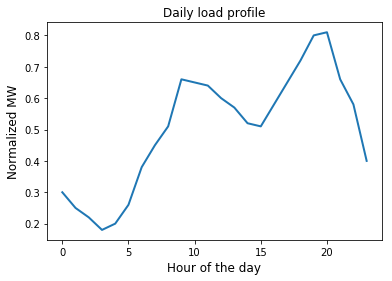

The load profile in Fig. 2 is representative of how much power might be consumed over the course of a day. This is a typical profile for many grids, with a small peak in the morning and a larger peak in the evening, with the least power demanded in the earliest hours of the morning. Unfortunately a linear model won't describe the behavior we see here, so we'll assume we need to use a polynomial basis in this and the following assignments. We need to pass the input data through a polynomial basis function $\phi$, just like we have in the previous assignments:

<center>$\boldsymbol{p}_{t+1} = w_{1}^{T}\phi(\boldsymbol{x}_{t}) + w_{2}^{T}\phi(\boldsymbol{x}_{T - 1})\ldots$</center>

For this assignment we'll use a polynomial basis function, noting that _each sample needs to be passed through it's own basis function_, learn the weights $w_{i}$ on a training data set, and test the model on a testing data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
#we'll use these helper functions to generate a polynomial basis on the feature data matrices X

def poly_basis_single_sample(x, k):
    #this function will help us quickly generate a polynomial basis
    #k is the largest polynomial degree the basis runs to
    out = []
    for i in range(k+1):
        #notice that first value of i will be 0, so the bias term is included
        out.append(np.power(x, i))
    return(np.asarray(out))

#this one is not required for this assignment but can be used; we will use in the next assignment
def poly_basis_multi_sample(X, k):
    out = []
    for sample_row in range(X.shape[0]):
        sample = X[sample_row]
        #poly basis returns an m feature x k power matrix, we need to vectorize it by using .flatten()
        poly = np.asarray(poly_basis_single_sample(sample, k)).flatten() 
        out.append(poly)
    return(np.asarray(out))

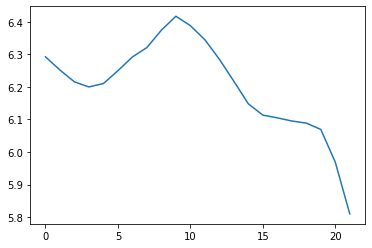

(22, 32)
(22,)


In [4]:
#import the training data
data = np.loadtxt("homework_3_data_ex_train.txt")

#in this example there are 5 feature dimensions over 24 hours
X_train_raw = data[:,0:4]

#in order to use 2 hours at a time, we need to pair two hour rows together, one hour at a time, passing each
#hour sample through the polynomial basis function with a chosen degree:
poly_degree = 3
X_train = []
for i in range(24 - 2):  #24 hours minus the order
    #get the individual sample for each time step you need, pass it through the polynomial basis function, vectorize
    t_0 = poly_basis_single_sample(X_train_raw[i,:], poly_degree).flatten()
    t_1 = poly_basis_single_sample(X_train_raw[i+1,:], poly_degree).flatten()
    X_train.append(np.concatenate((t_0, t_1)))
    
X_train = np.asarray(X_train)

#the last column is the output p_{t+1} we need to learn
#in order to save the data file, the Y column is 0-padded in the first two values, so we start from the third element
Y_train = data[:,5][2:]

plt.plot(Y_train)
plt.show()

#notice Y_train is only 22 hours long, since the model we'll train in the example is order two, we need the first
#and second hour of the day in order to predict the third hour, otherwise we'd need additional data from the
#previous day; to keep things simple we'll restrict ourselves to 24 hour windows
print(X_train.shape)
print(Y_train.shape)

In [5]:
#similarly we'll load the test data
#import the training data
data_test = np.loadtxt("homework_3_data_ex_test.txt")

X_test_raw = data_test[:,0:4]

poly_degree = 3
X_test = []
for i in range(24 - 2): 
    t_0 = poly_basis_single_sample(X_test_raw[i,:], poly_degree).flatten()
    t_1 = poly_basis_single_sample(X_test_raw[i+1,:], poly_degree).flatten()
    X_test.append(np.concatenate((t_0, t_1)))
    
X_test = np.asarray(X_test)

Y_test = data_test[:,5][2:]


Now we'll use LASSO to fit a polynomial basis to a time series model of order 2, and polynomial basis with degree 3

In [6]:
lasso_regressor = linear_model.Lasso(alpha=0.001, fit_intercept=False, tol=0.01, max_iter=10000)

#this fits the outputs Y to the polynomial basis of inputs in the range -2 to 2
lasso_regressor.fit(X_train, Y_train)

#these are the weights the model learns
w = lasso_regressor.coef_

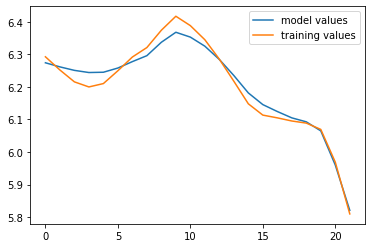

In [7]:
#here we plot our training data and model.

plt.plot(X_train.dot(w), label="model values")   #our model
plt.plot(Y_train, label="training values")   #our training data
plt.legend()
plt.show()

### Problem 1

In the above example we've split our data into a train and test set. Use the model $w$ we learned on the test data. X_test is reformatted so that each row is full sample, $x_{t}$ and $x_{t-1}$  How does the model perform on the test data? Plot the test data, the model predictions, and the [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error).

In [14]:
#insert your code here

### Problem 2

We're going to look at what happens when we overfit a model. 

Pass the training and test data through the basis function as above. Train a model $w$ with the training set using LASSO and the parameters given below. In one plot, plot the model applied to the training data and training output values. In another plot, draw the model on the test data and test output values. In your own words, describe what happens.

In [ ]:
#use these parameters for LASSO and the polynomial basis function

poly_degree = 9  #higher than our previous problem
alpha = 0.000001  #much smaller than our previous problem


In [ ]:
data_train = np.loadtxt("homework_3_data_ex_train.txt")

X_train_raw_prob_2 = data_train[:,0:4]
Y_train_raw_prob_2 = data_train[:,5][2:]

data_test = np.loadtxt("homework_3_data_ex_test.txt")

X_test_raw_prob_2 = data_test[:,0:4]
Y_test_raw_prob_2 = data_test[:,5][2:]

#pass each set data set X through the basis function above with the appropriate polynomial degree

In [ ]:
#insert code here

### Problem 3

Now we're going to overfit in another way. We're going to increase the order of the model. That is, we are going to see what happens when we use more historical data to forecast the future load. We happen to know that the true data was generated with order 2. This means that the value of load at a particular time depends on the last two load values (plust noise). Suppose we didn't know, and we guessed much higher without doing any sort of tests.

Train a model of order 7. You'll only have 24 - 7 values to predict, since you need the first 7 values of x to predict the first y. Adjust the for-loop in problem 1 to include 7 consecutive values, instead of 2. Just like problem 2, do one plot with the model on the training data and training output values, and a second plot with the model on the test data and the test output values.

In [8]:
#use these parameters for LASSO and the polynomial basis function

poly_degree = 3
alpha = 0.001

In [10]:
data_train = np.loadtxt("homework_3_data_ex_train.txt")

X_train_raw_prob_3 = data_train[:,0:4]
Y_train_raw_prob_3 = data_train[:,5][7:]  #we're picking up y from 7 onwards

data_test = np.loadtxt("homework_3_data_ex_test.txt")

X_test_raw_prob_3 = data_test[:,0:4]
Y_test_raw_prob_3 = data_test[:,5][7:]

#pass each set data set X through the basis function above with the appropriate polynomial degree

In [ ]:
#insert code here